# Rebinning Multi-Analyzer data from ID22 taken with a 2D detector

This notebooks presents how to agregate together on a same $2\theta$ grid all data coming from all pixels of the Eiger 2M detector.

## Introduction of the Multi-Analyzer stage for high resolution powder diffraction:

![eiger](multianalyzer3.png)
![multianalyzer](multianalyzer2.jpeg)

Please ensure you first read: [J. Appl. Cryst. (2021). 54, 1088-1099](https://doi.org/10.1107/S1600576721005288).

Author: Jérôme Kieffer, ESRF

In [1]:
%matplotlib nbagg
# Compile the library
!pwd
! cd .. && python3 setup.py build && cd -

/users/kieffer/workspace/multianalyzer/sandbox
INFO:root:Generating grammar tables from /usr/lib/python3.9/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.9/lib2to3/PatternGrammar.txt
INFO:multianalyzer.setup:Use setuptools with cython
INFO:multianalyzer.setup:Install requires: numpy >=1.19.5
running build
running build_py
running build_ext
/users/kieffer/workspace/multianalyzer/sandbox


In [2]:
import sys
import os
import time
import numpy
import h5py
import json
from matplotlib.pyplot import subplots
from matplotlib import colors
from scipy.signal import find_peaks
sys.path.append("../build/lib.linux-x86_64-3.9/")
from multianalyzer import MultiAnalyzer, ID22_bliss_parser, topas_parser
start_time = time.perf_counter()

In [3]:
#%%time
#Nota this cell takes a while to read all frames and perform a max-filter on the stack
#!pyFAI-average -m max -F numpy -o max.npy /mnt/data/ID22/MultiAnalyzer/LaB6_31keV_150921/LaB6_31keV_150921_0001/LaB6_31keV_150921_0001.h5::/1.1/instrument/eiger/data

<IPython.core.display.Javascript object>


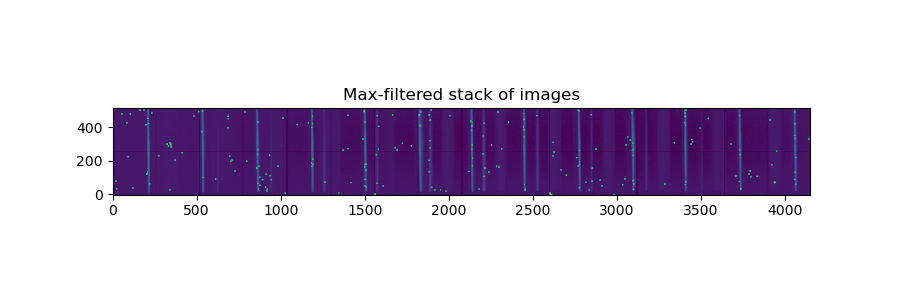

In [4]:
fig, ax = subplots(figsize=(9,3))
img = numpy.load("max.npy")
ax.imshow(img, norm=colors.LogNorm(vmin=1, vmax=65000), origin="lower")
_ = ax.set_title("Max-filtered stack of images")

## Read the configuration of the various analyzers

In [5]:
topas = "out7.pars"
print(open(topas).read())

Wavelength = 0.3541804473 (0.0000000053) 
Zero [MA6] =   0.00000000 (  0.00000000) 
    manom       mantth          dh 
 0.05651551  0.11281072        0.5000   (manom =   3.238100  mantth =   6.463578 )
       L1            L2 
     442.5000     238.0351
   centre       rollx      rolly      offset 
  286.3630  0.010565245  0.000000000 -0.209592460    MA0
  287.3468  0.005799983  0.000000000 -0.173620753    MA1
  288.3306  0.008820042  0.000000000 -0.138563058    MA2
  289.3144  0.005117273  0.000000000 -0.106395845    MA3
  290.2981  0.011531870  0.000000000 -0.069589678    MA4
  291.2819  0.013408102  0.000000000 -0.036933813    MA5
  292.2657  0.010356704  0.000000000  0.000000000    MA6
  293.2495  0.005954979  0.000000000  0.035727108    MA7
  294.2332  0.011711911  0.000000000  0.068024080    MA8
  295.2170  0.010718834  0.000000000  0.102703437    MA9
  296.2008  0.004283634  0.000000000  0.139223696    MA10
  297.1846  0.011034291  0.000000000  0.174401308    MA11
  298.1684  0

In [6]:
param = topas_parser(topas)
print(json.dumps(param, indent=2))

{
  "wavelength": 0.3541804473,
  "manom": 0.05651551,
  "mantth": 0.11281072,
  "L1": 442.5,
  "L2": 238.0351,
  "centre": [
    286.363,
    287.3468,
    288.3306,
    289.3144,
    290.2981,
    291.2819,
    292.2657,
    293.2495,
    294.2332,
    295.217,
    296.2008,
    297.1846,
    298.1684
  ],
  "rollx": [
    0.010565245,
    0.005799983,
    0.008820042,
    0.005117273,
    0.01153187,
    0.013408102,
    0.010356704,
    0.005954979,
    0.011711911,
    0.010718834,
    0.004283634,
    0.011034291,
    0.011214173
  ],
  "rolly": [
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0
  ],
  "offset": [
    -0.20959246,
    -0.173620753,
    -0.138563058,
    -0.106395845,
    -0.069589678,
    -0.036933813,
    0.0,
    0.035727108,
    0.06802408,
    0.102703437,
    0.139223696,
    0.174401308,
    0.209697416
  ]
}


## Read the ROI-collection from HDF5 file. 

This is a substential amount of data and takes up to a minute!

In [7]:
#!scp scisoft13:/data/id22/inhouse/id222108/id22/LaB6_35keV_mantr10_nozzle20_1/LaB6_35keV_mantr10_nozzle20_1_0001/LaB6_35keV_mantr10_nozzle20_1_0001.h5 /tmp    
#!md5sum /tmp/LaB6_35keV_mantr10_nozzle20_1_0001.h5
#!md5sum /mnt/data/ID22/MultiAnalyzer/LaB6_35keV_mantr10_nozzle20_1/id222108_LaB6_35keV_mantr10_nozzle20_1.h5
hdf5 = "/tmp/LaB6_35keV_mantr10_nozzle20_1_0001.h5"
print(f"Size of the input file: {os.stat(hdf5).st_size>>10} MB")

Size of the input file: 417209 MB


In [8]:
%%time 
hdf5_data = ID22_bliss_parser(hdf5)
print(hdf5_data)

{'roicol': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int32), 'arm': array([-9.999995 , -9.9999825, -9.999965 , ..., 55.00156  , 55.00159  ,
       55.0016225]), 'mon': array([1201., 1155., 1228., ..., 1220., 1199., 1125.]), 'tha': -3.2378, 'thd': -6.4755}
CPU times: user 28.6 s, sys: 4.1 s, total: 32.7 s
Wall time: 32.5 s


In [9]:
print("Shape of the ROI-collection:", hdf5_data["roicol"].shape)

Shape of the ROI-collection: (390000, 6656)


## Perform  the rebinning

In [10]:
# Ensure all units are consitent. Here lengths are in milimeters.
L = param["L1"]
L2 = param["L2"]
pixel = 75e-3

# Angles are all given in degrees
center = numpy.array(param["centre"])
psi = numpy.rad2deg(param["offset"])
rollx = numpy.rad2deg(param["rollx"])
rolly = numpy.rad2deg(param["rolly"])

# tha = hdf5_data["tha"]
# thd = hdf5_data["thd"]
tha = numpy.rad2deg(param["manom"])
thd = numpy.rad2deg(param["mantth"])

# Finally initialize the rebinning engine.
mma = MultiAnalyzer(L, L2, pixel, center, tha, thd, psi, rollx, rolly)

In [11]:
tha, thd

(3.238100200029399, 6.463578139832067)

In [12]:
roi_step = 1

<IPython.core.display.Javascript object>


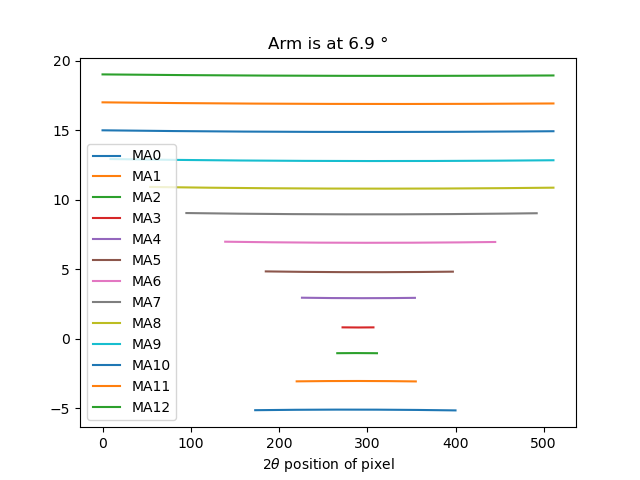

In [13]:
#Display the 2theta position of all ROI for a given arm position
arm = 6.9
fig, ax = subplots()
x = range(512)
for a in range(13):
    ax.plot(x, [mma.refine(i, a, arm, phi_max=8) for i in x], label=f"MA{a}")

ax.set_xlabel("Pixel index")
ax.set_xlabel(r"$2\theta$ position of pixel")
ax.set_title(f"Arm is at {arm} °")
_ = ax.legend()

In [14]:
%%time 
roicol = hdf5_data["roicol"]
arm = hdf5_data["arm"]
mon = hdf5_data["mon"]
res = mma.integrate(roicol, arm, mon, 3.383800, 45.099600, 3.5e-4, 90, 29, 40, resolution=1e-4)

CPU times: user 1min 28s, sys: 0 ns, total: 1min 28s
Wall time: 9.76 s


In [15]:
#Load the reference data:
ref = numpy.loadtxt("LaB6_35keV_all.xye").T

<IPython.core.display.Javascript object>


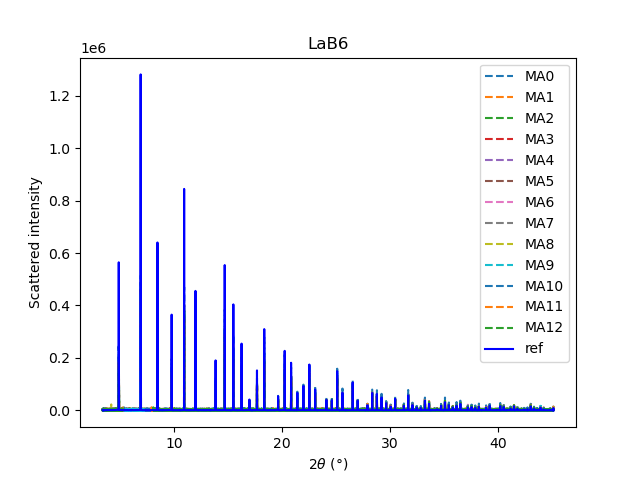

<ipython-input-16-0e06f22593c1>:2: RuntimeWarning: invalid value encountered in true_divide
  scale = ref[1].mean() / numpy.nanmean(res[1]/res[2])
<ipython-input-16-0e06f22593c1>:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(res[0], scale*res[1][i]/res[2][i], "--", label=f"MA{i}")
<ipython-input-16-0e06f22593c1>:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(res[0], scale*res[1][i]/res[2][i], "--", label=f"MA{i}")
<ipython-input-16-0e06f22593c1>:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(res[0], scale*res[1][i]/res[2][i], "--", label=f"MA{i}")
<ipython-input-16-0e06f22593c1>:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(res[0], scale*res[1][i]/res[2][i], "--", label=f"MA{i}")
<ipython-input-16-0e06f22593c1>:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(res[0], scale*res[1][i]/res[2][i], "--", label=f"MA{i}")
<ipython-input-16-0e06f22593c1>:4: RuntimeWarning: invalid

In [16]:
fig, ax = subplots()
scale = ref[1].mean() / numpy.nanmean(res[1]/res[2])
for i in range(0, 13, 1):
    ax.plot(res[0], scale*res[1][i]/res[2][i], "--", label=f"MA{i}")
ax.plot(ref[0],ref[1], "-b", label="ref")
ax.set_xlabel(r"$2\theta$ (°)")
ax.set_ylabel("Scattered intensity")
ax.set_title("LaB6")
ax.legend()

## Perform some basic profile analysis

This is not a Rietveld, nor a Pawley refinement but it gives some insights on the intrinsic width of the signal

In [17]:
pk = find_peaks(ref[1], width=(5, 50), prominence=1000, distance=400)

<IPython.core.display.Javascript object>


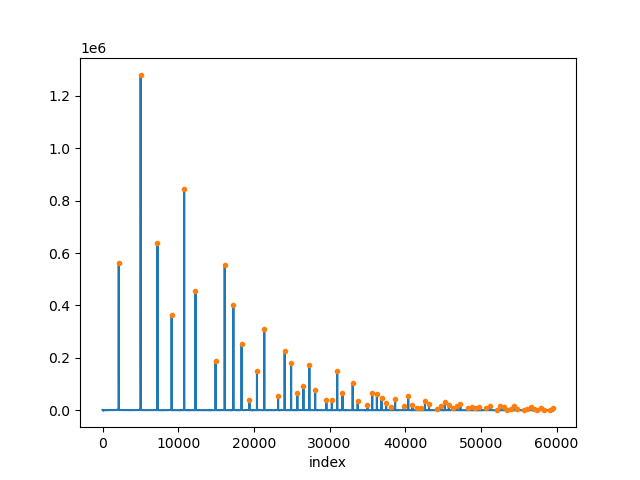

In [18]:
fig,ax = subplots()
ax.plot(ref[1])
ax.plot(pk[0], pk[1]["prominences"], ".")
_ = ax.set_xlabel("index")

In [19]:
%%time 
res = mma.integrate(roicol, arm, mon, 
                    tth_min=3.383800, tth_max=45.099600, dtth=3.5e-4, 
                    phi_max=90, 
                    roi_min=29, roi_max=512, roi_step=roi_step, 
                    resolution=1e-4)

CPU times: user 48min 27s, sys: 133 ms, total: 48min 28s
Wall time: 5min 30s


<IPython.core.display.Javascript object>


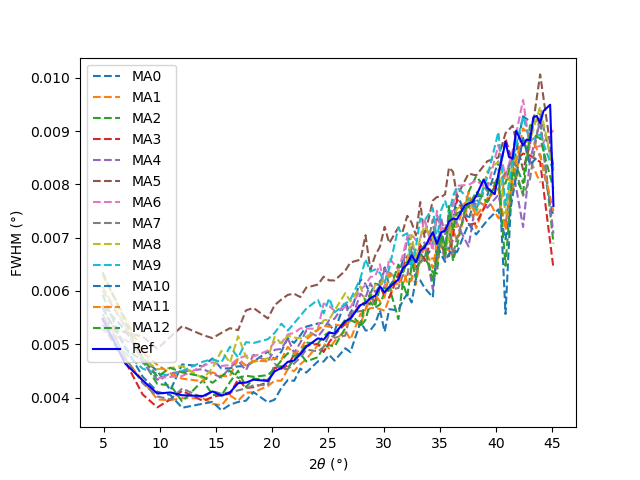

<ipython-input-20-cfad41b44438>:7: RuntimeWarning: invalid value encountered in true_divide
  sig = scale*res[1][i, :-1]/res[2][i, :-1]
<ipython-input-20-cfad41b44438>:7: RuntimeWarning: invalid value encountered in true_divide
  sig = scale*res[1][i, :-1]/res[2][i, :-1]
<ipython-input-20-cfad41b44438>:7: RuntimeWarning: invalid value encountered in true_divide
  sig = scale*res[1][i, :-1]/res[2][i, :-1]
<ipython-input-20-cfad41b44438>:7: RuntimeWarning: invalid value encountered in true_divide
  sig = scale*res[1][i, :-1]/res[2][i, :-1]
<ipython-input-20-cfad41b44438>:7: RuntimeWarning: invalid value encountered in true_divide
  sig = scale*res[1][i, :-1]/res[2][i, :-1]


In [20]:
fig, ax = subplots()
delta = (ref[0][-1] - ref[0][0])/(len(ref[0])-1)
delta1 = (res[0][-1] - res[0][0])/(len(res[0])-1)
ax.set_xlabel(r"$2\theta$ (°)")
ax.set_ylabel("FWHM (°)")
for i in range(0, 13, 1):
    sig = scale*res[1][i, :-1]/res[2][i, :-1]
    pks = find_peaks(sig, width=(10, 150), prominence=1000, distance=1000)
    ax.plot(res[0][:-1][pks[0]], delta1*pks[1]["widths"], "--", label=f"MA{i}")
ax.plot(ref[0][pk[0]], delta*pk[1]["widths"], "-b", label="Ref")
_ = ax.legend()

In [21]:
weights = numpy.array([float(i) for i in open("temp.res").read().split(",") 
                       if i.strip()]).reshape((13, -1))[:, 1]
sig_tot = (weights.reshape((13, -1)) * res[1]).sum(axis=0)
norm_tot = (weights.reshape((13, -1)) * res[2]).sum(axis=0)
intensity = sig_tot/norm_tot

<IPython.core.display.Javascript object>


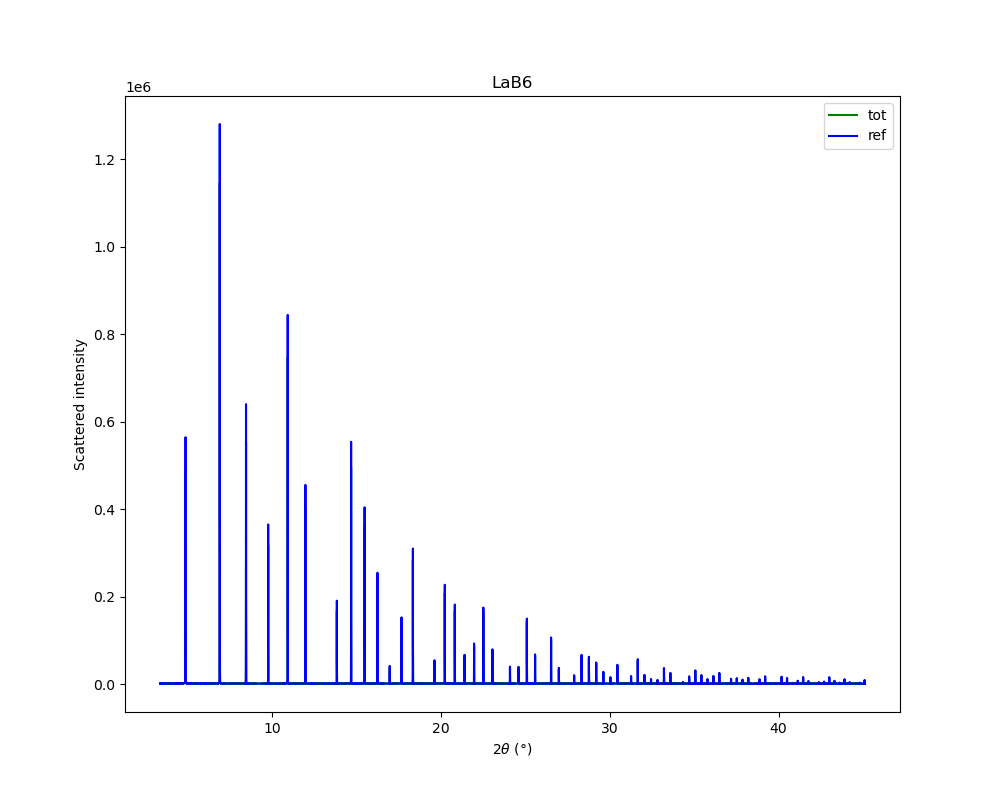

In [22]:
fig, ax = subplots(figsize=(10,8))
scale = ref[1].mean() / numpy.nanmean(intensity)
ax.plot(res[0],intensity*scale, "-g", label="tot")
ax.plot(ref[0],ref[1], "-b", label="ref")
ax.set_xlabel(r"$2\theta$ (°)")
ax.set_ylabel("Scattered intensity")
ax.set_title("LaB6")
ax.legend()

<IPython.core.display.Javascript object>


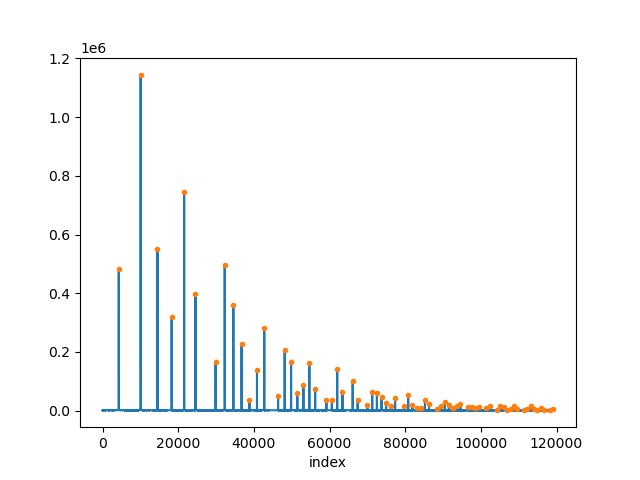

In [23]:
pki = find_peaks(intensity*scale, width=(10, 200), distance=800, prominence=1000)
fig,ax = subplots()
ax.plot(intensity*scale)
ax.plot(pki[0], pki[1]["prominences"], ".")
_ = ax.set_xlabel("index")

<IPython.core.display.Javascript object>


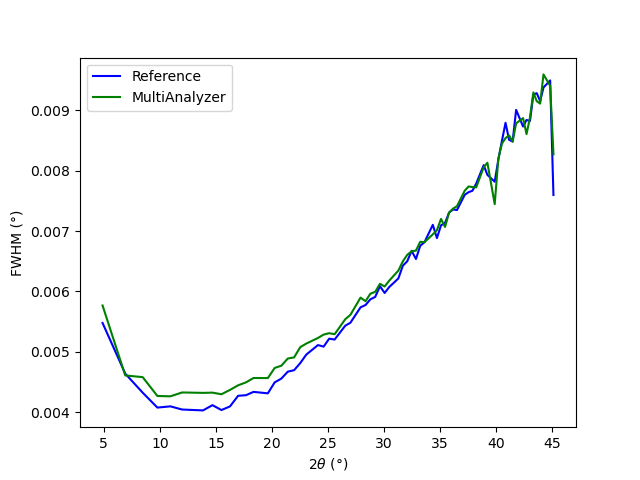

In [24]:
fig, ax = subplots()
delta = (ref[0][-1] - ref[0][0])/(len(ref[0])-1)
delta1 = (res[0][-1] - res[0][0])/(len(res[0])-1)
ax.set_xlabel(r"$2\theta$ (°)")
ax.set_ylabel("FWHM (°)")
ax.plot(ref[0][pk[0]], delta*pk[1]["widths"], "-b", label="Reference")
ax.plot(res[0][pki[0]], delta1*pki[1]["widths"], "-g", label="MultiAnalyzer")
_ = ax.legend()

## Now limit to Phi<10°

In [25]:
%%time 

phi_max = 10
res = mma.integrate(roicol, arm, mon, 
                    tth_min=3.383800, tth_max=45.099600, dtth=3.5e-4, 
                    phi_max=phi_max, 
                    roi_min=29, roi_max=512, roi_step=roi_step, 
                    resolution=1e-4)
sig_tot = (weights.reshape((13, -1)) * res[1]).sum(axis=0)
norm_tot = (weights.reshape((13, -1)) * res[2]).sum(axis=0)
intensity = sig_tot/norm_tot
scale = ref[1].mean() / numpy.nanmean(intensity)
pki = find_peaks(intensity*scale, width=(10, 200), distance=800, prominence=1000)

CPU times: user 48min 26s, sys: 180 ms, total: 48min 27s
Wall time: 5min 30s


<IPython.core.display.Javascript object>


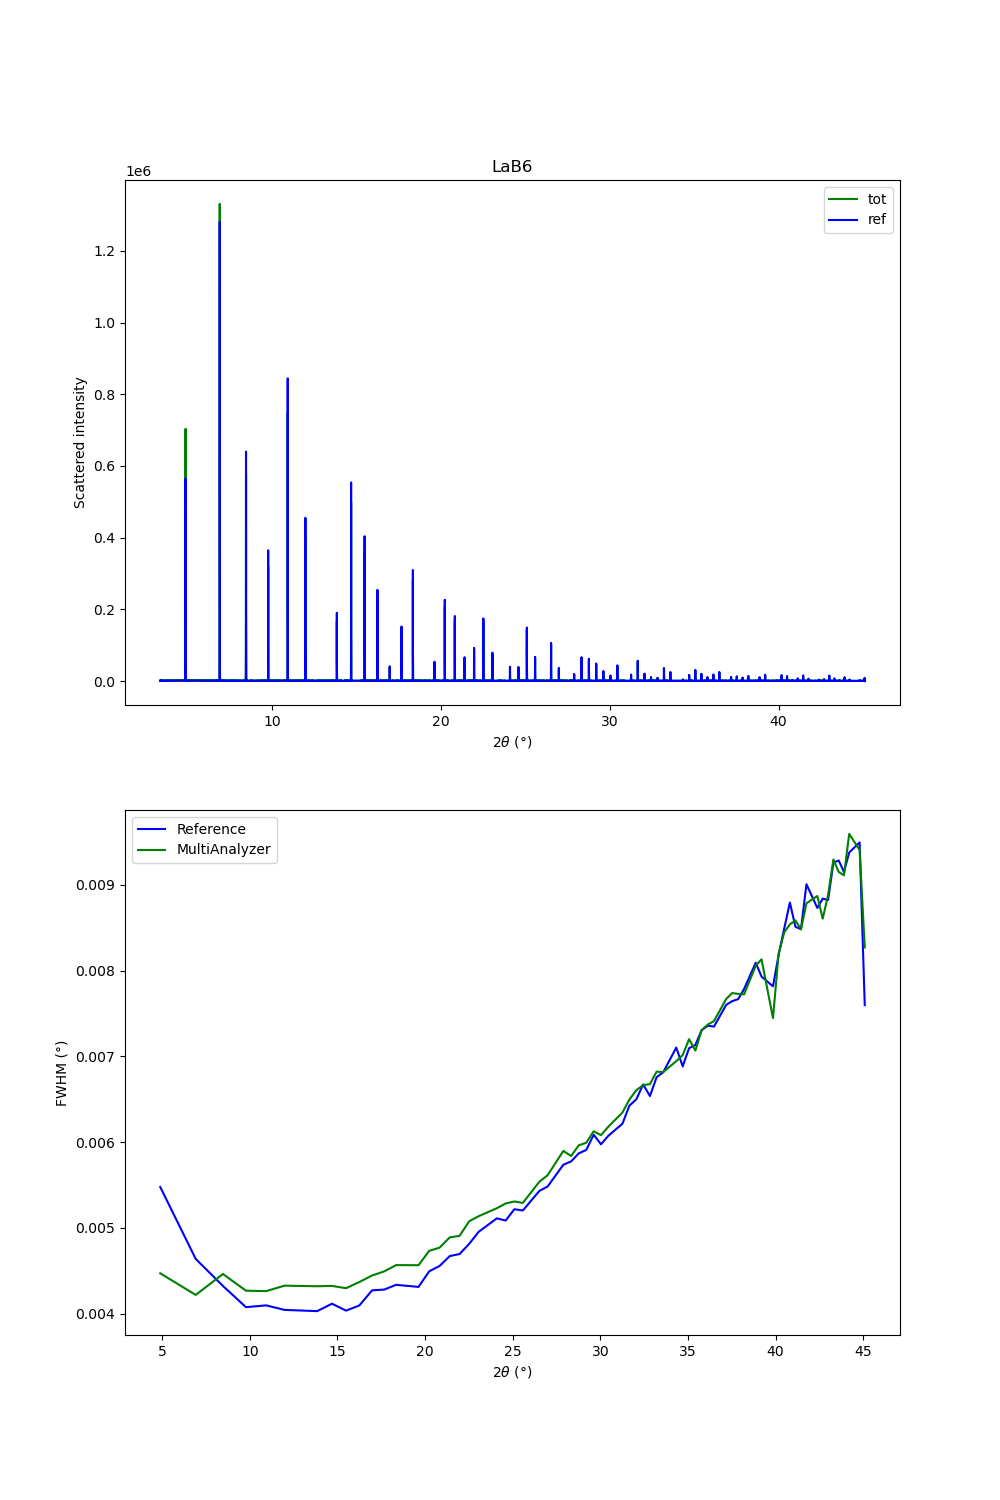

In [26]:
fig, ax = subplots(2,figsize=(10,15))

ax[0].plot(res[0],intensity*scale, "-g", label="tot")
ax[0].plot(ref[0],ref[1], "-b", label="ref")
ax[0].set_xlabel(r"$2\theta$ (°)")
ax[0].set_ylabel("Scattered intensity")
ax[0].set_title("LaB6")
ax[0].legend()

delta = (ref[0][-1] - ref[0][0])/(len(ref[0])-1)
delta1 = (res[0][-1] - res[0][0])/(len(res[0])-1)
ax[1].set_xlabel(r"$2\theta$ (°)")
ax[1].set_ylabel("FWHM (°)")
ax[1].plot(ref[0][pk[0]], delta*pk[1]["widths"], "-b", label="Reference")
ax[1].plot(res[0][pki[0]], delta1*pki[1]["widths"], "-g", label="MultiAnalyzer")
ax[1].legend()

pass

## Save data as text file

In [27]:
res3 = numpy.vstack((res[0], intensity*scale, numpy.sqrt(((weights*weights).reshape((13, -1)) * res[1]).sum(axis=0))*scale/norm_tot))
numpy.savetxt("LaB6.xye", res3.T, fmt='%.5f')

## Conclusion
This notebook explains how to rebin data coming from the new experimental setup from ID22.

In [28]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f}s")

Total execution time: 704.039s
